In [1]:
# Importar las bibliotecas necesarias
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

In [2]:
spark = SparkSession.builder.getOrCreate()

house_data = spark.read.csv("data/kc_house_data.csv",  inferSchema="true", header="true")
house_data.count()

21613

In [3]:
# Seleccionamos la columnas que vamos a usar :0
input_cols = ['bedrooms', 'bathrooms', 'floors']
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
final_data = assembler.transform(house_data)

In [4]:
#Los clustering con KMeans 🥺
kmeans = KMeans(featuresCol="features", k=4)
model = kmeans.fit(final_data)
predictions = model.transform(final_data)
predictions = predictions.withColumnRenamed("prediction", "cluster")

#predictions = model.transform(final_data)
predictions.show()


+----------+---------------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+--------------+-------+
|        id|           date|    price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|      features|cluster|
+----------+---------------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+--------------+-------+
|7129300520|20141013T000000| 221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650| [3.0,1.0,1.0]|      0|
|6414100192|20141209T000000| 538000.0|       3| 

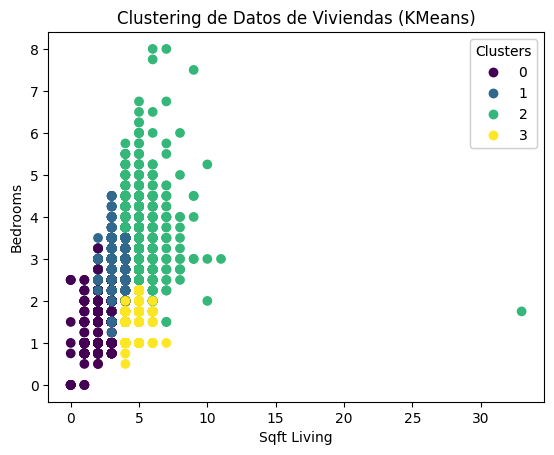

In [5]:
# Visualización de los resultados del clustering
predictions_pd = predictions.select('bedrooms', 'bathrooms', 'floors', 'cluster').toPandas()
fig, ax = plt.subplots()

# Scatter plot de los datos reales coloreados por clúster
scatter = ax.scatter(predictions_pd["bedrooms"], predictions_pd["bathrooms"], c=predictions_pd["cluster"], cmap="viridis", label='Datos reales')

# Añadir la leyenda manualmente
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

# Etiquetas y título
ax.set_xlabel('Sqft Living')
ax.set_ylabel('Bedrooms')
ax.set_title('Clustering de Datos de Viviendas (KMeans)')

# Mostrar el gráfico
plt.show()


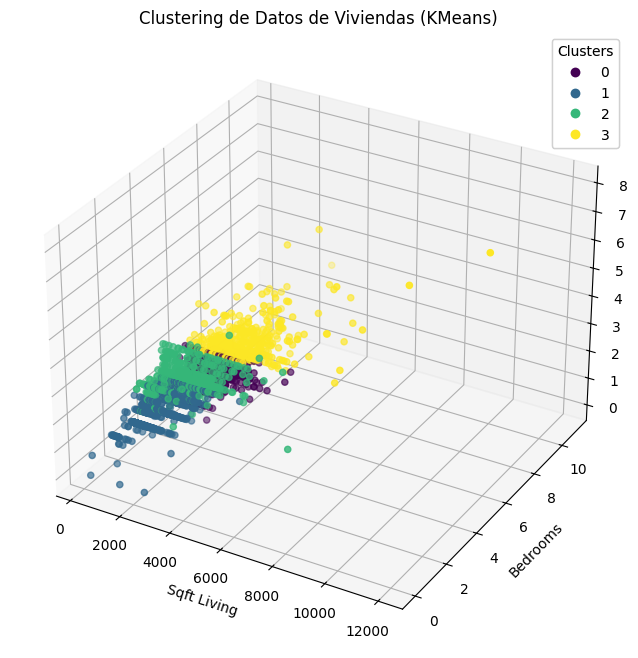

In [6]:
# Mostaramos los datos aleatorios y tomandos el 20%
sampled_data = final_data.sample(False, 0.2) 

# Los clustering con KMeans y renombra la columna de predicción
model = kmeans.fit(sampled_data)
predictions = model.transform(sampled_data)
predictions = predictions.withColumnRenamed("prediction", "cluster")

# Visualización de los resultados del clustering de manera tridimensional 😱
predictions_pd = predictions.select('sqft_living', 'bedrooms', 'bathrooms', 'floors', 'cluster').toPandas()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Ahora a colear los clúster :D
scatter = ax.scatter(predictions_pd["sqft_living"], predictions_pd["bedrooms"], predictions_pd["bathrooms"], c=predictions_pd["cluster"], cmap="viridis")

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

ax.set_xlabel('Sqft Living')
ax.set_ylabel('Bedrooms')
ax.set_zlabel('Bathrooms')
ax.set_title('Clustering de Datos de Viviendas (KMeans)')

plt.show()


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()

datos = spark.read.load("data/kc_house_data.CSV", format="csv", sep=",", inferSchema="true", header="true")

# feature_cols = ["bedrooms", "bathrooms",  "waterfront", "view", "condition", "grade", "sqft_above", "sqft_basement", "yr_built", "yr_renovated", "zipcode", "lat", "long", "sqft_living15", "sqft_lot15"]
feature_cols = ["bedrooms", "bathrooms",  "waterfront",  "condition", "grade", "sqft_basement", "yr_built"]


assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
datos = assembler.transform(datos)

lr = LinearRegression(featuresCol="features", labelCol="price")
lrModel = lr.fit(datos)

predictions = lrModel.transform(datos)

predictions.select("id", "price", "yr_built", "prediction").show()


+----------+---------+--------+------------------+
|        id|    price|yr_built|        prediction|
+----------+---------+--------+------------------+
|7129300520| 221900.0|    1955| 314309.9417653568|
|6414100192| 538000.0|    1951|508260.44573732093|
|5631500400| 180000.0|    1933|215254.39465674106|
|2487200875| 604000.0|    1965| 596673.9213241041|
|1954400510| 510000.0|    1987|498837.86241756286|
|7237550310|1225000.0|    2001| 1434045.923173502|
|1321400060| 257500.0|    1995| 299928.8688478302|
|2008000270| 291850.0|    1963|   340838.37736471|
|2414600126| 229500.0|    1960|350320.34901732113|
|3793500160| 323000.0|    2003|297052.65426432434|
|1736800520| 662500.0|    1965|  777263.528757358|
|9212900260| 468000.0|    1942|  410882.664181415|
| 114101516| 310000.0|    1927| 440114.3163423715|
|6054650070| 400000.0|    1977| 326572.8621011721|
|1175000570| 530000.0|    1900| 637449.7802253263|
|9297300055| 650000.0|    1979| 911223.2932671141|
|1875500060| 395000.0|    1994|

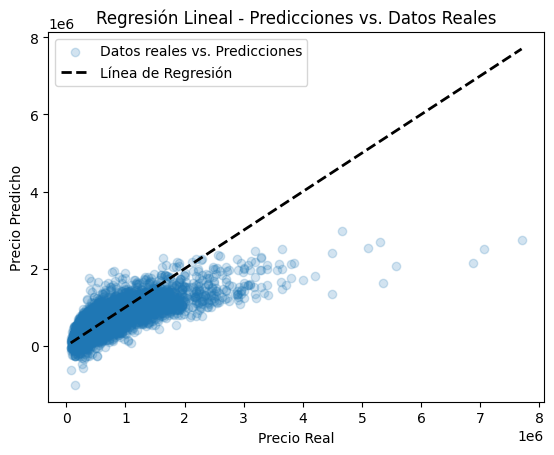

In [8]:
# Seleccionamos los datos que usaremos y usamos pandas para manipulacion y visuacion de datos
predictions_pd = predictions.select("bedrooms", "bathrooms", "waterfront", "condition", "grade", "sqft_basement", "yr_built", "price", "prediction").toPandas()

# Creamos el  gráfico de dispersión (scatter) con la línea de regresión
fig, ax = plt.subplots()
ax.scatter(predictions_pd["price"], predictions_pd["prediction"], label="Datos reales vs. Predicciones", alpha=0.2)

#Trasamos las lineas del eje x y y del punto min-max
ax.plot([predictions_pd["price"].min(), predictions_pd["price"].max()], [predictions_pd["price"].min(), predictions_pd["price"].max()], 'k--', lw=2, label="Línea de Regresión")

ax.set_xlabel('Precio Real')
ax.set_ylabel('Precio Predicho')
ax.set_title('Regresión Lineal - Predicciones vs. Datos Reales')
ax.legend()
plt.show()

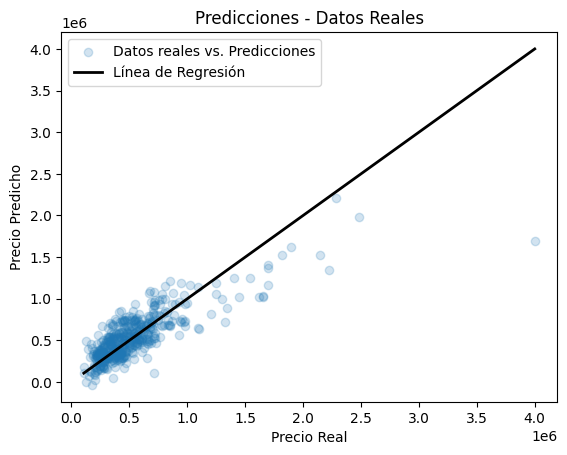

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()

datos = spark.read.load("data/kc_house_data.CSV", format="csv", sep=",", inferSchema="true", header="true")

feature_cols = ["bedrooms", "bathrooms", "waterfront", "condition", "grade", "sqft_basement", "yr_built"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
datos = assembler.transform(datos)

# Entrenamos los datos para dividirlos en entrenamiento y prueba
(train_data, test_data) = datos.randomSplit([0.8, 0.2], seed=42)


lr = LinearRegression(featuresCol="features", labelCol="price")
lr_model = lr.fit(train_data)

# Usamos los datos entrenados para las predicciones 
predictions = lr_model.transform(test_data)

# Seleccionamos aleatoriamente los dartoss para predecir y solo un 10% 
predictions_pd = predictions.sample(fraction=0.1, seed=42).select("bedrooms", "bathrooms", "waterfront", "condition", "grade", "sqft_basement", "yr_built", "price", "prediction").toPandas()


fig, ax = plt.subplots()
ax.scatter(predictions_pd["price"], predictions_pd["prediction"], label="Datos reales vs. Predicciones", alpha=0.2)
ax.plot([predictions_pd["price"].min(), predictions_pd["price"].max()], [predictions_pd["price"].min(), predictions_pd["price"].max()], 'k-', lw=2, label="Línea de Regresión")


ax.set_xlabel('Precio Real')
ax.set_ylabel('Precio Predicho')
ax.set_title('Predicciones - Datos Reales')
ax.legend()
plt.show()


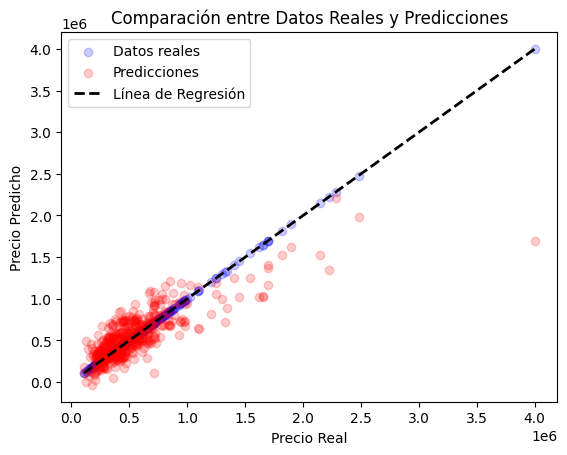

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()
datos = spark.read.load("data/kc_house_data.CSV", format="csv", sep=",", inferSchema="true", header="true")


feature_cols = ["bedrooms", "bathrooms", "waterfront", "condition", "grade", "sqft_basement", "yr_built"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
datos = assembler.transform(datos)

(train_data, test_data) = datos.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="price")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)
predictions_pd = predictions.sample(fraction=0.1, seed=42).select("bedrooms", "bathrooms", "waterfront", "condition", "grade", "sqft_basement", "yr_built", "price", "prediction").toPandas()

fig, ax = plt.subplots()

# Datos reales en azul
ax.scatter(predictions_pd["price"], predictions_pd["price"], label="Datos reales", color='blue', alpha=0.2)

# Predicciones en rojo
ax.scatter(predictions_pd["price"], predictions_pd["prediction"], label="Predicciones", color='red', alpha=0.2)


ax.plot([predictions_pd["price"].min(), predictions_pd["price"].max()], [predictions_pd["price"].min(), predictions_pd["price"].max()], 'k--', lw=2, label="Línea de Regresión")

ax.set_xlabel('Precio Real')
ax.set_ylabel('Precio Predicho')
ax.set_title('Comparación entre Datos Reales y Predicciones')
ax.legend()

plt.show()

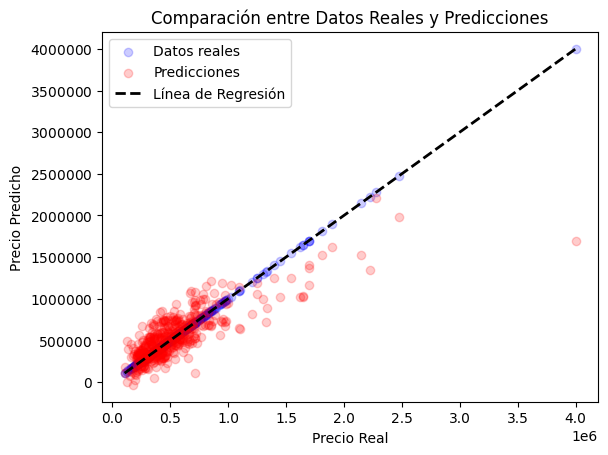

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from matplotlib.ticker import ScalarFormatter


spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()
datos = spark.read.load("data/kc_house_data.CSV", format="csv", sep=",", inferSchema="true", header="true")

feature_cols = ["bedrooms", "bathrooms", "waterfront", "condition", "grade", "sqft_basement", "yr_built"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
datos = assembler.transform(datos)

(train_data, test_data) = datos.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="price")
lr_model = lr.fit(train_data)


predictions = lr_model.transform(test_data)
predictions_pd = predictions.sample(fraction=0.1, seed=42).select("bedrooms", "bathrooms", "waterfront", "condition", "grade", "sqft_basement", "yr_built", "price", "prediction").toPandas()

# Creamos un gráfico de dispersión con los datos reales y predicciones en diferentes colores
fig, ax = plt.subplots()

ax.scatter(predictions_pd["price"], predictions_pd["price"], label="Datos reales", color='blue', alpha=0.2)

ax.scatter(predictions_pd["price"], predictions_pd["prediction"], label="Predicciones", color='red', alpha=0.2)

ax.plot([predictions_pd["price"].min(), predictions_pd["price"].max()], [predictions_pd["price"].min(), predictions_pd["price"].max()], 'k--', lw=2, label="Línea de Regresión")

ax.set_xlabel('Precio Real')
ax.set_ylabel('Precio Predicho')
ax.set_title('Comparación entre Datos Reales y Predicciones')
ax.legend()

# Escalamos los datos en formator estandar 
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='plain')
# ax.ticklabel_format(axis='x', style='plain')
plt.show()
